In [1]:
from dolfinx import cpp as _cpp
from dolfinx import geometry, fem, mesh, plot, io
from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, ComplexType
from ufl import (TrialFunction, Measure, TestFunction, dx, ds, grad, div, inner, lhs, rhs)

import numpy as np
import pandas as pd

from utils.dolfinx import BoundaryCondition, generate_boundary_measure, eval_pointvalues, project
from utils.plotting import Mpl1DPlotter, Mpl1DAnimator

from IPython.display import Video
from pathlib import Path

In [2]:
save_dir = "./results/1d-frequency-domain"
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [3]:
def generate_boundaries(points):
    return [(1, lambda x: np.isclose(x[0], points[0])), 
            (2, lambda x: np.isclose(x[0], points[1]))]

In [4]:
def dump_bilinear_forms(forms):
    for form in forms.items():
        print(f'Form: {form[0]}')
        am = fem.petsc.assemble_matrix(fem.form(form[1]))
        am.assemble()
        values = am.getValues(range(4), range(4))
        print('Real: \n', np.real(values))
        print('Imag: \n', np.imag(values))

In [5]:
def problem_setup(N: int,
                  points: list[float, float],
                  Theta0: float,
                  freq: float,
                  pressure,
                  fluid: str):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    # Mesh and function space definition
    domain = mesh.create_interval(MPI.COMM_WORLD, N, points)
    V = fem.FunctionSpace(domain, ("CG", 1))
    G = fem.FunctionSpace(domain, ("CG", 1))
    
    (u, theta) = TrialFunction(V), TrialFunction(G)
    (v, g) = TestFunction(V), TestFunction(G)
    
    # Definition of density and speed functions
    ro, c, eta, cv, ksi, alpha = fluids.loc[fluid, ['Density', 'Speed of sound', 'Viscosity', 
                                                    'Heat', 'Thermal conductivity', 'Thermal expansion']]
    ro, c, eta = ro, c, eta
    cv, ksi, alpha = cv, ksi, alpha
    
    # Construction of bilinear form and linear functional
    omega = freq * 2 * np.pi
    
    mm = ScalarType(ro) * inner(u, v) * dx
    aa = ScalarType(ro * c**2) * inner(grad(u), grad(v)) * dx
    cc = ScalarType(4./3 * eta) * inner(grad(u), grad(v)) * dx
    
    ss = ScalarType(cv) * inner(theta, g) * dx
    bb_1 = ScalarType(Theta0 * alpha * eta) * inner(theta, v.dx(0)) * dx
    bb_2 = ScalarType(Theta0 * alpha * eta) * inner(u.dx(0), g) * dx
    kk = ScalarType(ksi) * inner(grad(theta), grad(g)) * dx
    
    a00 = -omega**2 * mm + omega * 1.0j * cc + aa 
    a01 = -bb_1
    a10 = 1.0j * omega * bb_2
    a11 = 1.0j * omega * ss + kk 
    
    F = fem.form([[a00, a01],
                  [a10, a11]])
    
    boundaries = generate_boundaries(points)
    measure = generate_boundary_measure(boundaries, domain)
    
    u_D = lambda x: x[0] * 0.0
    theta_D = lambda x: x[0] * 0.0
    u_N1 = fem.Constant(domain, ScalarType(-pressure))
    u_N2 = fem.Constant(domain, ScalarType(0.0))
    theta_N = fem.Constant(domain, ScalarType(0.0))
    
    bcs = [BoundaryCondition("Dirichlet", 1, u_D, V, u, v, measure).bc,]
           #BoundaryCondition("Dirichlet", 1, theta_D, G, theta, g, measure).bc]
    nbcs = [BoundaryCondition("Neumann", 2, u_N1, V, u, v, measure).bc,
            BoundaryCondition("Neumann", 2, u_N2, V, u, v, measure).bc,
            BoundaryCondition("Neumann", 1, theta_N, V, theta, g, measure).bc,
            BoundaryCondition("Neumann", 2, theta_N, V, theta, g, measure).bc] 
    
    return {
        'Params': (N, points, fluid, ro, c, Theta0, omega),
        'FunctionSpace': (domain, V, u, v, G, theta, g),
        'Forms': (mm, aa, cc, ss, bb_1, bb_2, kk), 
        'Problem': (F, bcs, nbcs)
    }

In [6]:
def solve_problem(config):
    N, points, fluid, ro, c, Theta0, omega = config['Params']
    domain, V, u, v, G, theta, g = config['FunctionSpace']
    mm, aa, cc, ss, bb_1, bb_2, kk = config['Forms']
    F, bcs, nbcs = config['Problem']
    
    # Create initial condition
    # u_initial_condition = project(fem.Constant(domain, ScalarType(0.0)), domain, ('CG', 1))
    theta_initial_condition = project(fem.Constant(domain, ScalarType(0.0)), domain, ('CG', 1))
    # theta_d_initial_condition = project(fem.Constant(domain, ScalarType(0.0)), domain, ('CG', 1))
    
    uj = fem.Function(V)
    thetaj = fem.Function(G)
    
    # dump_bilinear_forms(dict(zip(['a00', 'a01', 'a10', 'a11'], [F[0][0], F[0][1], F[1][0], F[1][1]])))
    
    # Construct the left and right hand side of the problem
    a00 = fem.petsc.assemble_matrix(F[0][0])
    a01 = fem.petsc.assemble_matrix(F[0][1])
    a10 = fem.petsc.assemble_matrix(F[1][0])
    a11 = fem.petsc.assemble_matrix(F[1][1])
    map(PETSc.Mat.assemble, [a00, a01, a10, a11])

    A = PETSc.Mat().createNest([[a00, a01], 
                                [a10, a11]])
    A.assemble()
    
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.FIELDSPLIT)
    solver.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)
    
    L = nbcs[0]
    Z = nbcs[2] + nbcs[3]
        
    linear_form = fem.form([rhs(L), rhs(Z)])
    
    b = fem.petsc.assemble_vector_nest(linear_form)
    
    # Modify ('lift') the RHS for Dirichlet boundary conditions
    fem.petsc.apply_lifting_nest(b, F, bcs=bcs)

    # Sum contributions from ghost entries on the owner
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    bcs0 = fem.bcs_by_block(fem.extract_function_spaces(linear_form), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    x = PETSc.Vec().createNest([_cpp.la.petsc.create_vector_wrap(uj.x), 
                                _cpp.la.petsc.create_vector_wrap(thetaj.x)])
    
    solver.solve(b, x)
    uj.x.scatter_forward()
    thetaj.x.scatter_forward()
    
    return uj, thetaj

#### Available fluids

In [7]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity,Heat,Thermal conductivity,Thermal expansion
Fluid,,,,,,
Water,1000,1500,0.000894,4182.0,0.598,0.00015
Fuel oil,890,1360,2.022000,2090.0,0.150,0.00070
Oil,760,1470,0.000500,NaN,NaN,NaN
Glycerin,1260,1905,1.500000,NaN,NaN,NaN


In [8]:
config = problem_setup(N=100000, 
                       points=[0.0, 10.0],
                       Theta0=293.0,
                       freq=1e3,
                       pressure=1e10,
                       fluid='Fuel oil')

In [9]:
uj, thetaj = solve_problem(config)
N, points, _, ro, c, *_ = config['Params']
domain, *_ = config['FunctionSpace']

In [10]:
p = project(ro * c**2 * uj.dx(0), domain, ('CG', 1))

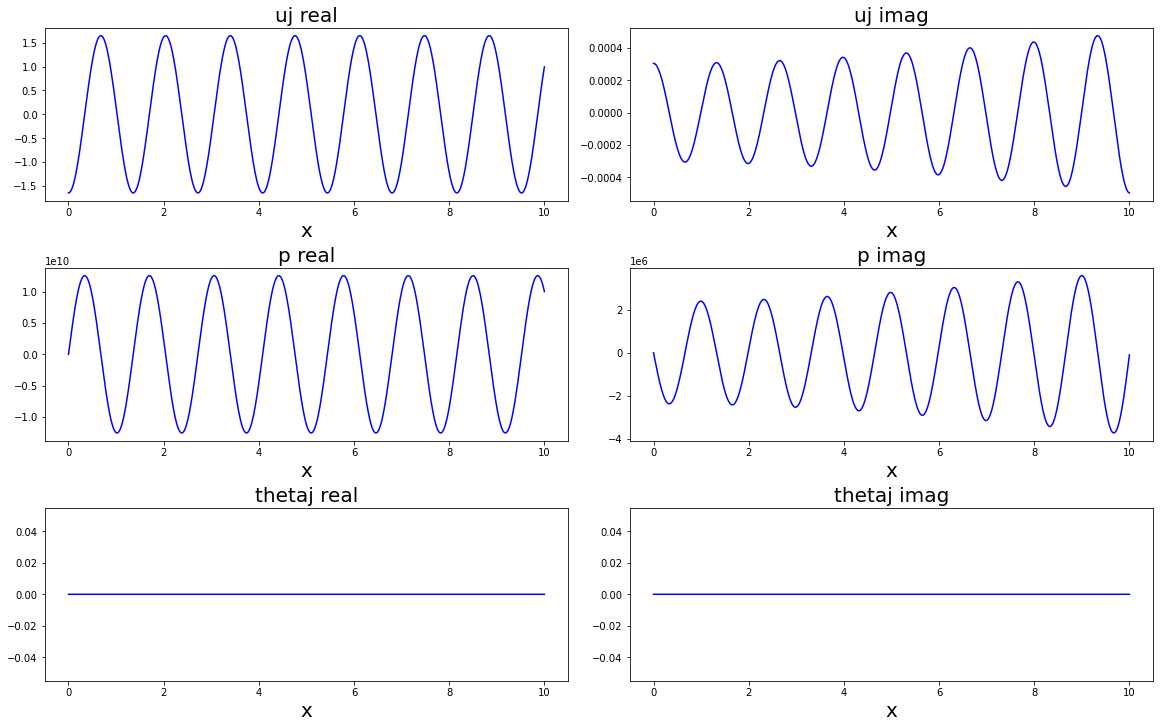

In [11]:
mpl = Mpl1DPlotter(layout=[['1', '2'], ['3', '4'], ['5', '6']])
mpl.update_figure(figsize=(16, 10), fontsize=20)
mpl.plot(uj, 'real', points, '1', 'uj real')
mpl.plot(uj, 'imag', points, '2', 'uj imag')
mpl.plot(p, 'real', points, '3', 'p real')
mpl.plot(p, 'imag', points, '4', 'p imag')
mpl.plot(thetaj, 'real', points, '5', 'thetaj real')
mpl.plot(thetaj, 'imag', points, '6', 'thetaj imag')